## **Machine Learning - WNBA Playoffs Prediction**
This notebook will focus on the undestanding of the data. We will be using SQLite to store the data due to its scalability & the fact that it's a relational schema.

https://docs.python.org/3/library/sqlite3.html

Import sqlite3 and connect to database file

### **Imports**

In [1]:
import pandas as pd
import sqlite3
import prep_utils as pu 
import raw_prep_utils as ru
import sys
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### **Database Connection Setup**

In [2]:
db = sqlite3.connect("db/ac.db")
db_cur = db.cursor()

[df_awards, df_coaches, df_players_teams, df_players, df_series_post, df_teams_post, df_teams] = pu.db_to_pandas(db)

In [3]:
final_rick = pu.calc_team_power_rat(df_players_teams,df_awards,df_players,df_teams,1)
print(final_rick.columns)
#oi = ru.merge_all_raw_data(df_teams,df_players_teams,df_coaches,df_awards,df_teams_post,1)
#print(oi.to_string())


Mean Squared Error for G: 0.2606472440944882
Feature importance for G:
fg%: 0.13471514396347242
PPM: 0.09713660827934542
PER: 0.09671052039938337
3pt%: 0.09095337378581295
ft%: 0.08556465351403571
assists: 0.07923976388730111
PF: 0.07644778391060791
turnovers: 0.07005365364957575
steals: 0.05354908368320435
blocks: 0.052148597512384334
rebounds: 0.05083951297024278
dRebounds: 0.0507015221250263
oRebounds: 0.04735060008310256
dq: 0.013388916563613478
player_awards: 0.0012002656728916097

Mean Squared Error for C-F: 0.31105555555555564
Feature importance for C-F:
blocks: 0.22750229350136603
PER: 0.13816941011534134
turnovers: 0.09950409156029044
fg%: 0.0883075773892918
PPM: 0.06607227605967475
ft%: 0.06484442179706233
assists: 0.06311992338919215
dRebounds: 0.05826488537738744
oRebounds: 0.04803312108193295
steals: 0.043311255861429455
PF: 0.04210382959357263
3pt%: 0.028207089398297004
rebounds: 0.024704391021662865
dq: 0.007855433853498867
player_awards: 0.0

Mean Squared Error for C: 

***Prepare Coaches Dataframe***

In [4]:
df_new_coaches = pu.prepare_coaches(df_coaches, df_awards,1)
df_new_coaches = pu.group_coaches(df_new_coaches)
print(df_new_coaches.to_string())

Dropping Attribute lgID in Coaches...
Creating attribute coach previous regular season win ratio...
Creating attribute coach playoffs win ratio...
Creating attribute coach playoffs count...
Creating attribute coach awards count...
Dropping attribute post_wins..
Dropping attribute post_losses..
Dropping attribute won..
Dropping attribute lost..

Coaches Null Verification:
year                    0
tmID                    0
coachID                 0
coach_reg_season_wr     0
coach_po_season_wr      0
coach_playoffs_count    0
coach_awards            0
dtype: int64
     year tmID     coachID  coach_reg_season_wr  coach_po_season_wr  coach_playoffs_count  coach_awards
0       1  CHA  dunntr01wc             0.000000            0.000000                     0             0
1       1  CLE  hugheda99w             0.000000            0.000000                     0             0
2       1  DET  liebena01w             0.000000            0.000000                     0             0
3       1  HOU 

***Prepare Players Dataframe***


In [5]:
df_new_players_teams = pu.prepare_player_teams(df_players_teams,df_awards,1)
#df_new_players_teams['PostPER'] = ((df_new_players_teams['PostfgMade'] * 85.910) + (df_new_players_teams['PostSteals'] * 53.897) + (df_new_players_teams['PostthreeMade'] * 51.757) + (df_new_players_teams['PostftMade'] * 46.845) + (df_new_players_teams['PostBlocks'] * 39.190) + (df_new_players_teams['PostoRebounds'] * 39.190) + (df_new_players_teams['PostAssists'] * 34.677) + (df_new_players_teams['PostdRebounds'] * 14.707) - (df_new_players_teams['PostPF'] * 17.174) - ((df_new_players_teams['PostftAttempted'] - df_new_players_teams['PostftMade']) * 20.091) - ((df_new_players_teams['PostfgAttempted'] - df_new_players_teams['PostfgMade']) * 39.190) - (df_new_players_teams['PostTurnovers'] * 53.897)) * (np.where(df_new_players_teams['PostMinutes'] == 0, 0, 1 / df_new_players_teams['PostMinutes']))
#df_new_players_teams['PER'] = ((df_new_players_teams['fgMade'] * 85.910) + (df_new_players_teams['steals'] * 53.897) + (df_new_players_teams['threeMade'] * 51.757) + (df_new_players_teams['ftMade'] * 46.845) + (df_new_players_teams['blocks'] * 39.190) + (df_new_players_teams['oRebounds'] * 39.190) + (df_new_players_teams['assists'] * 34.677) + (df_new_players_teams['dRebounds'] * 14.707) - (df_new_players_teams['PF'] * 17.174) - ((df_new_players_teams['ftAttempted'] - df_new_players_teams['ftMade']) * 20.091) - ((df_new_players_teams['fgAttempted'] - df_new_players_teams['fgMade']) * 39.190) - (df_new_players_teams['turnovers'] * 53.897)) * (np.where(df_new_players_teams['minutes'] == 0, 0, 1 / df_new_players_teams['minutes']))

Dropping Attribute lgID in Players_Teams...
        playerID  year tmID    GP    GS  minutes  points  oRebounds  dRebounds  rebounds  assists  steals  blocks  turnovers     PF  fgAttempted  fgMade  ftAttempted  ftMade  threeAttempted  threeMade   dq  PostGP  PostGS  PostMinutes  PostPoints  PostoRebounds  PostdRebounds  PostRebounds  PostAssists  PostSteals  PostBlocks  PostTurnovers  PostPF  PostfgAttempted  PostfgMade  PostftAttempted  PostftMade  PostthreeAttempted  PostthreeMade  PostDQ  player_awards
0     abrossv01w     2  MIN   0.0   0.0      0.0     0.0        0.0        0.0       0.0      0.0     0.0     0.0        0.0    0.0          0.0     0.0          0.0     0.0             0.0        0.0  0.0     0.0     0.0          0.0         0.0            0.0            0.0           0.0          0.0         0.0         0.0            0.0     0.0              0.0         0.0              0.0         0.0                 0.0            0.0     0.0              0
1     abrossv01w     3

***Prepare Teams Dataframe***

In [6]:
df_new_teams = pu.prepare_teams(df_teams,df_teams_post,1)
print(df_new_teams.to_string())

Dropping divID in Teams...
Dropping ldID in Teams...
Dropping seeded in Teams...
Dropping tmORB, tmDRB, tmTRB, opptmORB, opptmDRB, opptmTRB in Teams...
Dropping GP, homeW, homeL, awayW, awayL, confW, confL, attend, name, confID, franchID & arena in Teams...
Converting Target PLAYOFF to binary onTeams...
Creating attribute winrate Teams...
Dropping won & lost in Teams...
Creating attribute PlayOffs winrate Teams...
     year tmID  rank  playoff   o_fgm   o_fga  o_ftm  o_fta  o_3pm  o_3pa  o_oreb  o_dreb   o_reb  o_asts   o_pf  o_stl   o_to  o_blk   o_pts   d_fgm   d_fga  d_ftm  d_fta  d_3pm  d_3pa  d_oreb  d_dreb   d_reb  d_asts   d_pf  d_stl   d_to  d_blk   d_pts   min  team_playoffs_count   Winrate  PO_Winrate
0       9  ATL   0.0        0     0.0     0.0    0.0    0.0    0.0    0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0    0.0    0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0    0.0     0.0  6825                    

In [7]:
df_new_player_rankings = pu.prepare_players_for_ranking(df_players_teams, df_awards)
feature_importance, df_new_players = pu.feature_importance_players(df_new_player_rankings, df_players,df_teams)



Mean Squared Error for G: 0.2710322834645669
Feature importance for G:
fg%: 0.1354034876173702
PER: 0.10179935076075906
3pt%: 0.09544569264431914
ft%: 0.09245331968482118
PPM: 0.08947068273462298
PF: 0.08407039610240581
assists: 0.06772653713525369
turnovers: 0.06371670231162532
oRebounds: 0.05362721097031128
rebounds: 0.05213223604185448
dRebounds: 0.05136190254315456
steals: 0.051173543304480366
blocks: 0.04597567218394141
dq: 0.013388335742201387
player_awards: 0.0022549302228790295

Mean Squared Error for C-F: 0.31683333333333336
Feature importance for C-F:
blocks: 0.19725266674774158
PER: 0.12089836181620985
assists: 0.11813608261837065
turnovers: 0.10261307095709343
fg%: 0.08699197280630683
dRebounds: 0.07349622868784442
PPM: 0.07169870933668275
ft%: 0.06790279113755482
PF: 0.035546000374636
oRebounds: 0.03544530605448258
3pt%: 0.029428129469810722
steals: 0.027279398313667456
rebounds: 0.022939940976789676
dq: 0.010371340702809232
player_awards: 0.0

Mean Squared Error for C: 0

In [8]:
dfp_copy = df_new_players.copy()

df_rating_regular = pu.ranking_players(feature_importance, dfp_copy)
print('Best players in the regular season: ')
print(df_rating_regular)


Best players in the regular season: 
        playerID  year    rating
1074  jacksla01w     8  0.508609
1155  parkeca01w     9  0.500470
1580  catchta01w     3  0.500445
204   jacksla01w     4  0.497858
1655  leslili01w     5  0.484469
...          ...   ...       ...
543   berezva01w     9  0.042038
860   weberma01w     8  0.041944
934   robincr01w     8  0.040872
959   oneilkr01w     9  0.038659
1531  chambco01w     8  0.000000

[1805 rows x 3 columns]


In [9]:
df_rating_playoffs = pu.ranking_playoff_players(feature_importance, dfp_copy)
print('Best players in the playoffs: ')
print(df_rating_playoffs)

Best players in the playoffs: 
        playerID  year  PostRating
395    zollsh01w     9    0.063140
1393  zirkozu01w     4    0.063140
657   zellosh01w    10    0.367943
835    zarafr01w     6    0.375604
1322  zakalok01w     1    0.049791
...          ...   ...         ...
33    abrossv01w     5    0.226233
45    abrossv01w     6    0.068212
59    abrossv01w     7    0.068212
81    abrossv01w     9    0.236798
0     abrossv01w     2    0.068212

[1805 rows x 3 columns]


In [10]:
df_new_players = pd.merge(df_new_players, df_rating_regular, on=['playerID', 'year'], how='left')
df_new_players = pd.merge(df_new_players, df_rating_playoffs, on=['playerID', 'year'], how='left')
ratings = pu.team_player_ratings(df_new_players, df_teams)
ratings2 = pd.merge(ratings, df_teams[['year', 'tmID', 'playoff','rank']], on=['year', 'tmID'], how='left')
sorted_power_ratings = ratings2.sort_values(by=['year', 'cum_power_rating'], ascending=False)


    
print(sorted_power_ratings)
# Group by year and select the top 6 teams
top_teams_by_year = sorted_power_ratings.groupby('year').head(8)

# Count how many of the top 8 teams for each year made the playoffs
playoffs_made_by_year = top_teams_by_year.groupby('year')['playoff'].apply(lambda x: (x == 'Y').sum()).reset_index()

# Print or use the results
for index, row in playoffs_made_by_year.iterrows():
    print('Year ' + str(row['year']) + ' based on Power Ratings ' + str(row['playoff']) + '/8 best teams made the playoffs')

print('Ranking System Accuracy: ' + str(playoffs_made_by_year['playoff'].sum()/ (8*len(playoffs_made_by_year))) + '%')




     year tmID  cum_power_rating playoff  rank
132    10  DET          0.469528       Y     3
134    10  LAS          0.402271       Y     3
133    10  IND          0.343408       Y     1
140    10  SEA          0.340829       Y     2
137    10  PHO          0.306762       Y     1
..    ...  ...               ...     ...   ...
11      1  POR          0.000000       N     7
12      1  SAC          0.000000       Y     3
13      1  SEA          0.000000       N     8
14      1  UTA          0.000000       N     5
15      1  WAS          0.000000       Y     4

[142 rows x 5 columns]
Year 1 based on Power Ratings 3/8 best teams made the playoffs
Year 2 based on Power Ratings 5/8 best teams made the playoffs
Year 3 based on Power Ratings 5/8 best teams made the playoffs
Year 4 based on Power Ratings 4/8 best teams made the playoffs
Year 5 based on Power Ratings 4/8 best teams made the playoffs
Year 6 based on Power Ratings 5/8 best teams made the playoffs
Year 7 based on Power Ratings 8/8 

In [11]:

power_ratings = pu.team_power_rating(df_teams, df_new_players)
sorted_power_ratings = power_ratings.sort_values(by=['year', 'PowerRating'], ascending=[True, False])
    
print(sorted_power_ratings)
# Group by year and select the top 6 teams
top_teams_by_year = sorted_power_ratings.groupby('year').head(8)

# Count how many of the top 8 teams for each year made the playoffs
playoffs_made_by_year = top_teams_by_year.groupby('year')['playoff'].apply(lambda x: (x == 'Y').sum()).reset_index()

# Print or use the results
for index, row in playoffs_made_by_year.iterrows():
    print('Year ' + str(row['year']) + ' based on Power Ratings ' + str(row['playoff']) + '/8 best teams made the playoffs')

print('Ranking System Accuracy: ' + str(playoffs_made_by_year['playoff'].sum()/ (8*len(playoffs_made_by_year))) + '%')

     year tmID  PowerRating playoff  rank
5       1  LAS     0.347454       Y     1
8       1  NYL     0.346557       Y     1
3       1  HOU     0.338551       Y     2
12      1  SAC     0.325896       Y     3
9       1  ORL     0.319849       Y     3
..    ...  ...          ...     ...   ...
135    10  MIN     0.278293       N     5
136    10  NYL     0.276179       N     7
131    10  CON     0.271761       N     6
130    10  CHI     0.265302       N     5
138    10  SAC     0.240209       N     6

[142 rows x 5 columns]
Year 1 based on Power Ratings 8/8 best teams made the playoffs
Year 2 based on Power Ratings 8/8 best teams made the playoffs
Year 3 based on Power Ratings 8/8 best teams made the playoffs
Year 4 based on Power Ratings 7/8 best teams made the playoffs
Year 5 based on Power Ratings 7/8 best teams made the playoffs
Year 6 based on Power Ratings 7/8 best teams made the playoffs
Year 7 based on Power Ratings 7/8 best teams made the playoffs
Year 8 based on Power Ratings 8

In [12]:
best_colleges = pu.best_colleges(df_players_teams,df_teams,df_players)


print(best_colleges)

                    college  TotalPlayoffAppearances  CollegeRank
88                Tennessee                       21            1
17              Connecticut                       17            2
31                  Georgia                       15            3
86                 Stanford                       12            4
48           Louisiana Tech                       11            5
..                      ...                      ...          ...
80               Seton Hall                        1           14
25    Florida International                        1           14
82     Southern Mississippi                        1           14
50                    Maine                        1           14
0   Academy of Sport Moscow                        1           14

[113 rows x 3 columns]


In [13]:
awards = pu.player_awards(df_new_players,df_awards)


# get a player, order by year
player = awards[awards['playerID'] == 'leslili01w']
player = player.sort_values(by=['year'], ascending=[True])

print(player)


        playerID  year  award  cumulative_awards
2750  leslili01w     1      0                0.0
2751  leslili01w     2      3                0.0
2752  leslili01w     3      2                3.0
2753  leslili01w     4      0                5.0
2754  leslili01w     5      2                5.0
2755  leslili01w     6      0                7.0
2756  leslili01w     7      2                7.0
2757  leslili01w     8      0                9.0
2758  leslili01w     9      1                9.0
2759  leslili01w    10      0               10.0


In [14]:
teams = pu.team_ratings(sorted_power_ratings,10)
team = teams[teams['tmID'] == 'HOU']
print(team)

     year tmID  PowerRating playoff  rank  cum_Rating
3       1  HOU     0.338551       Y     2    0.000000
19      2  HOU     0.297318       Y     4    0.338551
35      3  HOU     0.287858       Y     2    0.317935
52      4  HOU     0.311565       Y     2    0.307909
65      5  HOU     0.258591       N     6    0.308823
78      6  HOU     0.279476       Y     3    0.298777
92      7  HOU     0.286968       Y     3    0.295560
105     8  HOU     0.277066       N     5    0.294333
119     9  HOU     0.263310       N     5    0.292174


In [15]:
colleges = pu.teams_colleges(df_new_players,best_colleges,df_teams)

colleges = colleges[colleges['tmID'] == 'IND']

ordered_colleges = colleges.sort_values(by=['year', 'CollegeRank'], ascending=[True, True])

print(ordered_colleges)

   tmID  year  CollegeRank   min  rank
43  IND     1     5.168872  6425     7
44  IND     2     5.448031  6475     6
45  IND     3     4.569650  6425     4
46  IND     4     5.996073  6875     5
47  IND     5     6.759708  6850     6
48  IND     6     4.771264  6925     2
49  IND     7     7.064672  6850     3
50  IND     8     8.205236  6875     2
51  IND     9     6.474676  6950     4
52  IND    10     6.009819  6925     1


Final Table for Testing

In [16]:
merged_data = pu.merge_all_data(df_new_coaches,df_new_teams,df_new_players_teams, ratings)
merged_data.drop('coachID',axis = 1, inplace = True)
merged_data = merged_data[merged_data['year'] != 1]



merged_data = pd.merge(merged_data, final_rick, on=['tmID', 'year'], how='left')

### **Feature Selection**
We will preparate the data in each table, by cleaning & formatting it so that it can be easily used by the machine learning models afterwards.

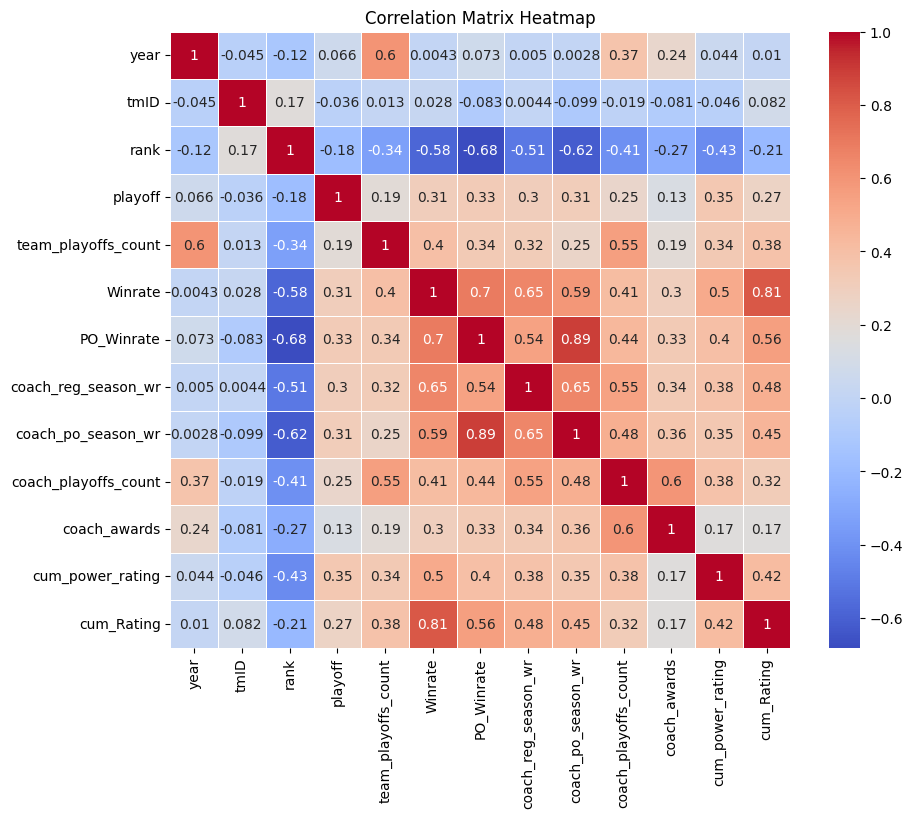

Random Forest Accuracy: 0.6923076923076923
Logistic Regression Accuracy: 0.6923076923076923
Support Vector Machine Accuracy: 0.6923076923076923
Gradient Boosting Accuracy: 0.6538461538461539


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


from sklearn.decomposition import PCA

import feature_selection as fs

label_encoder = LabelEncoder()


merged_data = merged_data.drop(columns=['o_fgm', 'o_fga', 'o_ftm', 'o_fta',
       'o_3pm', 'o_3pa', 'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_pf',
       'o_stl', 'o_to', 'o_blk', 'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta',
       'd_3pm', 'd_3pa', 'd_oreb', 'd_dreb', 'd_reb', 'd_asts', 'd_pf',
       'd_stl', 'd_to', 'd_blk', 'd_pts', 'min','p_GP', 'p_GS', 'p_minutes',
       'p_points', 'p_oRebounds', 'p_dRebounds', 'p_rebounds', 'p_assists',
       'p_steals', 'p_blocks', 'p_turnovers', 'p_PF', 'p_fgAttempted',
       'p_fgMade', 'p_ftAttempted', 'p_ftMade', 'p_threeAttempted',
       'p_threeMade', 'p_dq', 'p_PostGP', 'p_PostGS', 'p_PostMinutes',
       'p_PostPoints', 'p_PostoRebounds', 'p_PostdRebounds', 'p_PostRebounds',
       'p_PostAssists', 'p_PostSteals', 'p_PostBlocks', 'p_PostTurnovers',
       'p_PostPF', 'p_PostfgAttempted', 'p_PostfgMade', 'p_PostftAttempted',
       'p_PostftMade', 'p_PostthreeAttempted', 'p_PostthreeMade', 'p_PostDQ',
       'p_player_awards'], axis = 1)

"""
merged_data.drop(columns=['o_fgm', 'o_fga', 'o_ftm', 'o_fta',
       'o_3pm', 'o_3pa', 'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_pf',
       'o_stl', 'o_to', 'o_blk', 'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta',
       'd_3pm', 'd_3pa', 'd_oreb', 'd_dreb', 'd_reb', 'd_asts', 'd_pf',
       'd_stl', 'd_to', 'd_blk', 'd_pts', 'min','p_minutes'], axis = 1, inplace = True)
"""




merged_data['tmID'] = label_encoder.fit_transform(merged_data['tmID'])
correlation_matrix = merged_data.corr()
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()
#merged_data = fs.aggregate_stats_features(merged_data)

x = merged_data.drop('playoff', axis=1)
y = merged_data['playoff']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Create a dictionary of classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"{name} Accuracy: {accuracy}")